# Start kit for Task 1 - Sleep stage decoding transfer learning challenge

We recommand you to read the 'LeaderboardDataGuide' and visit the https://beetl.ai to get familar with data and tasks before you read this start kit.

<p> &#10071; <b>Important</b> &#10071; </p>
For the competition, please MAKE SURE that your model and uploaded labels are reproducible. We will run winner's code and generate the label to compare with the uploaded labels.

## Objective of the tutorial

In this start kit, we used 10 example subjects from [Physionet Sleep Cassette Data](https://physionet.org/content/sleep-edfx/1.0.0/) to show an example pipeline of the challenge including:

- Environment Setup
- Sleep Data loading
- Source and target domain data organisation
- Training and evaluation procedure using an example shallow CNN, using [BrainDecode](https://braindecode.org)

This tutorial is a adaptation of [Hubert Banville work](https://github.com/hubertjb/dl-eeg-tutorial)

References

> <p>&#128218; Schirrmeister, Robin Tibor, et al. "Deep learning with convolutional neural networks for EEG decoding and visualization." Human brain mapping 38.11 (2017): 5391-5420. </p>

## Environment Setup

1. Install pytorch from http://pytorch.org/ (you don't need to install torchvision).
1. Install latest release of braindecode via pip: `pip install braindecode`
1. You will also need mne, matplotlib, scikit-learn and pandas
1. If you want to automatically download the data, you could install the helper code with `pip install git+https://github.com/sylvchev/beetl-competition`

Let's import packages and set random seed. 

In [13]:
%matplotlib inline

In [14]:
from braindecode.util import set_random_seeds
from braindecode.util import np_to_var, var_to_np
import matplotlib.pyplot as plt 
import numpy as np
from numpy.random import RandomState
import os.path as osp
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from util.shallow_net import EEGShallowClassifier
from util.utilfunc import get_balanced_batches
from util.preproc import plot_confusion_matrix


cuda = torch.cuda.is_available()
print('gpu: ', cuda)
device = 'cuda' if cuda else 'cpu'

seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
rng = RandomState(seed)
set_random_seeds(seed=seed, cuda=cuda)

gpu:  True


## Loading Sleep Data

In this tutorial, we will assume source group is subjects 0-4, target group is subject 5-9. We will assume we have labels for source group (subject 0, 1, 2, 3, 4) and only for a subset of target subjects 5, 6 and 7.

In the following, we will split the data as such:
- training: data from subjects 0, 1, 2, 3, 4 (source) and 5, 6 (target)
- validation: data from subject 7 (target)
- test: data from subjects 8 and 9 (target)

Loading source data and part of the target group, here we just train on source and target together as an example, without using more complex transfer learning methods. Please come up with your own approach.

To download the data, you could either get directely the data from [Figshare](https://figshare.com/articles/dataset/sleeptutorialdata_zip/14779407) or use our dedicated [package](https://github.com/sylvchev/beetl-competition). To follow this tutorial, you need to provide the path to your data, called `savebase` below:

In [15]:
from beetl.task_datasets import BeetlSleepTutorial, BeetlSleepSource, BeetlSleepLeaderboard, BeetlMILeaderboard
ds = BeetlSleepTutorial()
path = ds.download()
X, y, info = ds.get_data()


In [16]:
# Directly download data and indicate their location:
savebase = path #"/home/moja/mne_data/MNE-beetlsleepleaderboard-data/sleep_target"#"/home/moja/mne_data/physionet-sleep-data"#"C:\\Path\\to\\data"

with open(osp.join(savebase, "headerInfo.npy"), 'rb') as f:
        info = pickle.load(f)

X_source, y_source = [], []
for i_train in range(5):
    with open(osp.join(savebase, "s{}r1X.npy".format(i_train)), 'rb') as f:
        X_source.append(pickle.load(f))
    with open(osp.join(savebase, "s{}r1y.npy".format(i_train)), 'rb') as f:
        y_source.append(pickle.load(f))
X_source = np.concatenate(X_source)
y_source = np.concatenate(y_source)
print("Source: there are {} trials with {} electrodes and {} time samples".format(*X_source.shape))

X_target, y_target = [], []
for i_target in range(5, 7):
    with open(osp.join(savebase, "s{}r1X.npy".format(i_target)), 'rb') as f:
        X_target.append(pickle.load(f))
    with open(osp.join(savebase, "s{}r1y.npy".format(i_target)), 'rb') as f:
        y_target.append(pickle.load(f))
X_target = np.concatenate(X_target)
y_target = np.concatenate(y_target)
print("Target: there are {} trials with {} electrodes and {} time samples".format(*X_target.shape))

X_train = np.concatenate([X_source, X_target])
y_train = np.concatenate([y_source, y_target])
print("Combining source and target for training:")
print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))

i_val = 7
X_val, y_val = [], []
with open(osp.join(savebase, "s{}r1X.npy".format(i_val)), 'rb') as f:
    X_val = pickle.load(f)
with open(osp.join(savebase, "s{}r1y.npy".format(i_val)), 'rb') as f:
    y_val = pickle.load(f)
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))

X_test, y_test = [], []
for i_test in range(8, 10):
    with open(osp.join(savebase, "s{}r1X.npy".format(i_test)), 'rb') as f:
        X_test.append(pickle.load(f))
    with open(osp.join(savebase, "s{}r1y.npy".format(i_test)), 'rb') as f:
        y_test.append(pickle.load(f))
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Source: there are 5127 trials with 2 electrodes and 3000 time samples
Target: there are 1497 trials with 2 electrodes and 3000 time samples
Combining source and target for training:
Train:  there are 6624 trials with 2 electrodes and 3000 time samples

Validation: there are 969 trials with 2 electrodes and 3000 time samples

Test: there are 2257 trials with 2 electrodes and 3000 time samples


In [17]:
# or use beetl-competition helper code
from beetl.task_datasets import BeetlSleepTutorial
dataset = BeetlSleepTutorial()
X_train, y_train, info = dataset.get_data(subjects=range(7))
X_val, y_val, _ = dataset.get_data(subjects=[7])
X_test, y_test, _ = dataset.get_data(subjects=range(8, 10))

print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Train:  there are 6624 trials with 2 electrodes and 3000 time samples

Validation: there are 969 trials with 2 electrodes and 3000 time samples

Test: there are 2257 trials with 2 electrodes and 3000 time samples


**Warning** 
Data are not normalized and labels are not balanced. Please come up with your strategy.

## Training a CNN

Here, we use a shallow CNN structure as an example, you should replace it with your own algorithm here.

In [18]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        mean = np.mean(X, axis=2, keepdims=True)
        # Here normalise across the window, when channel size is not large enough
        # In motor imagery kit, we put axis = 1, across channel as an example
        std = np.std(X, axis=2, keepdims=True)
        X = (X - mean) / std
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32)*1e3
        self.y = y.astype(np.int64)

train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)

In [19]:
input_time_length = X_train.shape[2]
in_chans = X_train.shape[1]

model = EEGShallowClassifier(in_chans, 6, input_time_length, return_feature=False)
if cuda:
    model.cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)

Epoch 0
Train  Loss: 0.64865
Train  Accuracy: 75.1%
Valid  Loss: 1.05695
Valid  Accuracy: 59.2%
[[111   6   0   0   0   0]
 [ 47  30  10   0   0   2]
 [ 34  46 312   9   2   0]
 [ 18   4   9  36  13   0]
 [  3   0   0  29  50   0]
 [ 61  67  35   0   0  35]]
Normalized confusion matrix


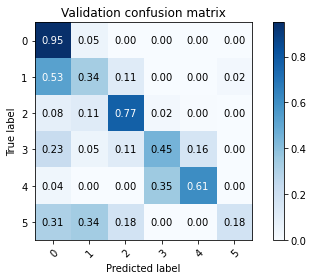

Epoch 1
Train  Loss: 0.64085
Train  Accuracy: 77.0%
Valid  Loss: 0.96953
Valid  Accuracy: 64.2%
[[112   5   0   0   0   0]
 [ 46  27  14   0   0   2]
 [ 19  10 371   0   0   3]
 [ 18   0  37  23   2   0]
 [  7   0   7  47  21   0]
 [ 55  58  17   0   0  68]]
Normalized confusion matrix


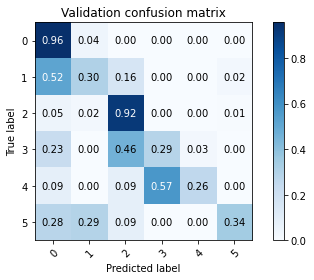

Epoch 2
Train  Loss: 0.45181
Train  Accuracy: 83.4%
Valid  Loss: 0.84176
Valid  Accuracy: 66.4%
[[111   6   0   0   0   0]
 [ 50  23  14   0   0   2]
 [ 18  24 341  10   1   9]
 [  7   6  11  38  18   0]
 [  2   0   0  12  68   0]
 [ 61  68   7   0   0  62]]
Normalized confusion matrix


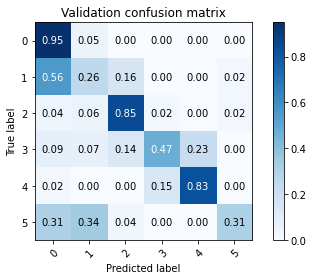

Epoch 3
Train  Loss: 0.44783
Train  Accuracy: 83.5%
Valid  Loss: 1.17234
Valid  Accuracy: 56.6%
Epoch 4
Train  Loss: 0.41072
Train  Accuracy: 84.9%
Valid  Loss: 1.12457
Valid  Accuracy: 60.0%
Epoch 5
Train  Loss: 0.40250
Train  Accuracy: 85.6%
Valid  Loss: 1.13371
Valid  Accuracy: 61.3%
Epoch 6
Train  Loss: 0.38822
Train  Accuracy: 86.5%
Valid  Loss: 0.96922
Valid  Accuracy: 67.5%
[[115   2   0   0   0   0]
 [ 52  23  12   0   0   2]
 [ 30  15 350   2   1   5]
 [ 16   0  24  20  19   1]
 [  2   0   1  14  65   0]
 [ 64  45   8   0   0  81]]
Normalized confusion matrix


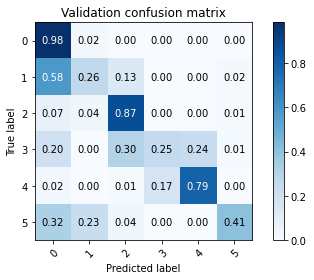

Epoch 7
Train  Loss: 0.40180
Train  Accuracy: 85.6%
Valid  Loss: 1.03759
Valid  Accuracy: 65.1%
Epoch 8
Train  Loss: 0.33686
Train  Accuracy: 87.8%
Valid  Loss: 1.15892
Valid  Accuracy: 62.6%
Epoch 9
Train  Loss: 0.37055
Train  Accuracy: 87.5%
Valid  Loss: 1.24131
Valid  Accuracy: 61.9%
time is 52.7673237323761


In [20]:
savename = "cnn_model_sleep.pth"

total_epoch = -1
Tlosses, Taccuracies = [], []
Vlosses, Vaccuracies = [], []
highest_acc = 0

start = time.time()
batch_size = 60
for i_epoch in range(10):
    total_epoch += 1
    # Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True, batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:, :, :, None]
        batch_y = train_set.y[i_trials]
        # convert from ndarray to torch tensor
        net_in = np_to_var(batch_X)
        net_target = np_to_var(batch_y)
        if cuda:
            net_in = net_in.cuda()
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(total_epoch))
    average_acc, average_loss = [], []
    
    # here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False, batch_size=60)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:,:,:,None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp=toutputs.cpu()
                outputs=temp.detach().numpy()
            else:
                temp=toutputs.cpu()
                outputs=np.concatenate((outputs,temp.detach().numpy()))
        net_target=np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
        
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            if accuracy>=highest_acc:
                torch.save({
                    'in_chans': in_chans,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'n_classes': 6,
                    'input_time_length':input_time_length
                }, savename)

                highest_acc=accuracy
                plot_confusion_matrix(dataset.y, predicted_labels, classes=['0', '1', '2', '3', '4', '5'], 
                                      normalize=True, title='Validation confusion matrix')
                plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end=time.time()

print('time is {}'.format(end-start))

## Plotting results

Plot training and validation curve, model was saved according to validation accuracy

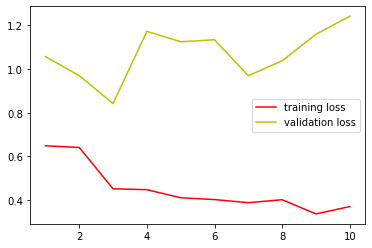

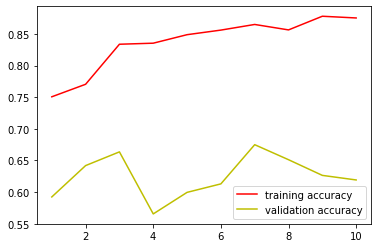

In [21]:
t = np.arange(0., len(Tlosses), 1)+1
plt.plot(t, Tlosses, 'r', t, Vlosses, 'y')
plt.legend(('training loss', 'validation loss'))
plt.show()

plt.figure()
plt.plot(t, Taccuracies, 'r', t, Vaccuracies, 'y')
plt.legend(('training accuracy', 'validation accuracy'))
plt.show()

## Prediction for target group

Load the saved model make prediction on the subjects from new target group

testset Loss: 0.86091
testset Accuracy: 72.2%
[[425  32   2   0   0   5]
 [ 28  32  17   0   0  10]
 [ 13   5 763   9   0  33]
 [  6   1 177  43  17   1]
 [  1   0  24  57 193   0]
 [  0  12 173   5   0 173]]
Normalized confusion matrix


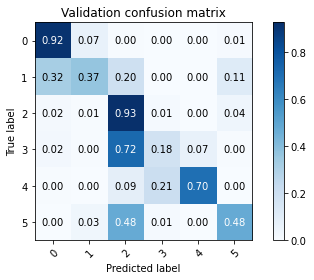

In [22]:
input_time_length = X_train.shape[2]
in_chans = X_train.shape[1]

model = EEGShallowClassifier(in_chans, 6, input_time_length, return_feature=False)
if cuda:
    model.cuda()
checkpoint = torch.load(savename)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc, average_loss = [], []
setname = 'testset'
dataset = test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False, batch_size=30)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
    batch_X = dataset.X[i_trials][:, :, :, None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp=toutputs.cpu()
        outputs=temp.detach().numpy()
    else:
        temp=toutputs.cpu()
        outputs=np.concatenate((outputs,temp.detach().numpy()))
net_target=np_to_var(dataset.y)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(
    setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, classes=['0', '1', '2', '3', '4', '5'], 
                      normalize=True, title='Validation confusion matrix')
plt.show()